# Privacy Policies Through Time

*An exploration of how privacy policies have evolved and reacted to different legislative and media events throughout the years.*



In [1]:
# project imports
import env
from build_master_index import MASTER_CSV, PROBLEM_COMPANIES
from wayback_search import POLICY_DIR


# python & package imports
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2

## Dataset Introduction

This project has put together a historical dataset containing all of the privacy policy revisions of various companies with the help of the Internet Archive's [Wayback Machine](https://archive.org/web/).

Here we import the master csv of the dataset and prepare it for analysis.

In [2]:
# import and prepare the dataframe
df = pd.read_csv(MASTER_CSV)
df.policy_date = pd.to_datetime(df.policy_date)
df.company = pd.Categorical(df.company)
df['company_id'] = df.company.cat.codes

# sanity-check: check for any policy paths that do not exist
assert len(df[~pd.Series([os.path.exists(os.path.join(POLICY_DIR, x)) for x in df.policy_path])]) == 0

# sometimes duplicate csv rows appear because of overlap in the
# dates of two configurations; they are the same policy most likely
# so we just drop the duplicate
print('Policy count before dropping duplicates: {}'.format(len(df)))
df = df[~df.duplicated('policy_path')]

# some companies proved more difficult than others when gathering
# privacy policies, so we drop them here (the policies are left
# as part of the original dataset because they are valid policies,
# but we do not have all the revisions)
print('Policy count before removing problematic companies: {}'.format(len(df)))
print('Company count before removing problematic companies: {}'.format(len(df.company.unique())))
df = df[~df.company.str.contains('|'.join(PROBLEM_COMPANIES))]
print('Final policy count: {}'.format(len(df)))

Policy count before dropping duplicates: 310
Policy count before removing problematic companies: 295
Company count before removing problematic companies: 21
Final policy count: 267


A quick look inside the dataframe shows the available columns, the mix of companies, and a range of policy dates

In [3]:
df.sample(n=5)

,company,policy_date,policy_url,policy_path,company_id
170,nytimes,2008-08-10,http://web.archive.org/web/20080901063330/http...,nytimes/nytimes-2008-08-10.txt,11
74,facebook,2010-12-22,http://web.archive.org/web/20101231191335/http...,facebook/facebook-2010-12-22.txt,4
25,apple,2007-06-29,http://web.archive.org/web/20070630044333/http...,apple/apple-2007-06-29.txt,2
22,apple,2001-06-04,http://web.archive.org/web/20010605001045/http...,apple/apple-2001-06-04.txt,2
260,verizon,2001-04-19,http://web.archive.org/web/20020606030746/http...,verizon/verizon-2001-04-19.txt,18


## Dataset Metadata

Here we explore the dataset metadata and begin to explore what's inside.

How many and what companies are covered?

In [4]:
companies = df.company.unique()
print('Companies: {}'.format(', '.join(list(companies))))
print('Count: {}'.format(len(companies)))

Companies: 1password, amazon, apple, cisco, facebook, fitbit, goodreads, google, intuit, netflix, nytimes, smud, target, twitter, uber, verizon, walmart, washingtonpost
Count: 18


How many policies are there?

In [5]:
policies = df.policy_path.unique()
# sanity-check: we removed duplicates so this should be the same
assert len(df) == len(policies)
print("Count of policies (number of rows in the dataset): {}".format(len(df)))

Count of policies (number of rows in the dataset): 267


How many policies per company?

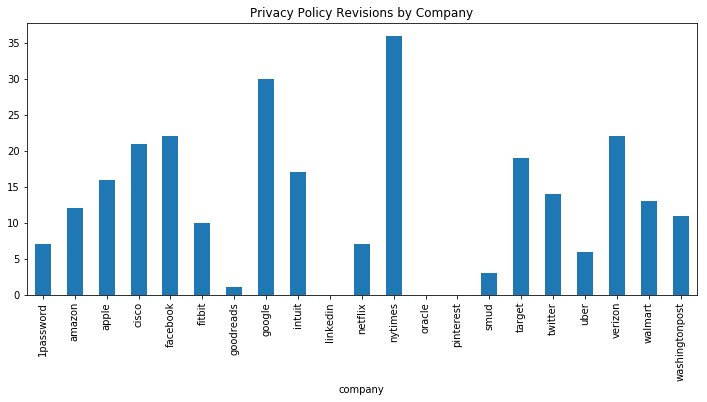

In [6]:
grouped = df.groupby('company').policy_path.count()
_ = grouped.plot.bar(title='Privacy Policy Revisions by Company', figsize=(12, 5))

What date range do the policies cover?

In [7]:
print('Oldest policy: {}'.format(min(df.policy_date).strftime('%Y-%m-%d')))
print('Most recent policy: {}'.format(max(df.policy_date).strftime('%Y-%m-%d')))

Oldest policy: 1999-06-09
Most recent policy: 2019-01-22


How many policies by year?

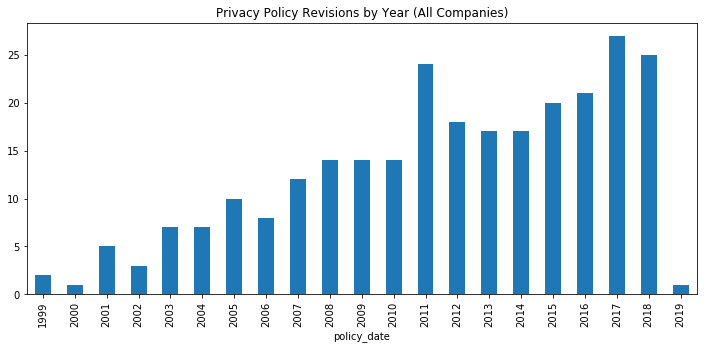

In [8]:
grouped = df.groupby([df.policy_date.dt.year]).policy_path.count()
_ = grouped.plot.bar(title='Privacy Policy Revisions by Year (All Companies)', figsize=(12, 5))

## The Privacy Policies

Now let's explore the policies themselves. We'll start by pulling all of the policy text into the dataframe, and then running some pandas cmds to gather metadata about the texts.

In [9]:
def get_policy_text(row):
    """
    Creates a pd.Series of full text from policies

    Args:
        row: pd.Series, row of policy index dataframe
        
    Returns:
        pd.Series, a new row with 'policy_text' col
    """
    page = ''
    with open(os.path.join(POLICY_DIR, row['policy_path']), 'r', encoding='utf-8') as f:
        page = f.read()
    row['policy_text'] = page
    return row

Looking inside again shows the same as before with the addition of the new text column

In [10]:
df = df.apply(get_policy_text, axis=1)
df.sample(n=10)

,company,policy_date,policy_url,policy_path,company_id,policy_text
255,uber,2013-07-13,http://web.archive.org/web/20140122053622/http...,uber/uber-2013-07-13.txt,17,\nYou are using an outdated browser. Please up...
47,cisco,2010-03-31,http://web.archive.org/web/20100404015546/http...,cisco/cisco-2010-03-31.txt,3,\nHome |\nSkip to Content |\nSkip to Navigatio...
88,fitbit,2014-12-09,http://web.archive.org/web/20150103022306/http...,fitbit/fitbit-2014-12-09.txt,5,\nFitbit\nProducts\nEveryday\nFitbit Zip®\nFit...
306,washingtonpost,2017-06-16,http://web.archive.org/web/20170630231159/http...,washingtonpost/washingtonpost-2017-06-16.txt,20,2 Desktop notifications are on &nbsp; | Turn ...
225,target,2011-04-08,http://web.archive.org/web/20110502151207/http...,target/target-2011-04-08.txt,15,\n<!---->\nTarget.com Home Page\nSearch\nFind ...
66,facebook,2007-05-24,http://web.archive.org/web/20070630042429/http...,facebook/facebook-2007-05-24.txt,4,\nEmail:\nPassword:\nForgot Password?\nRegiste...
61,facebook,2005-06-28,http://web.archive.org/web/20060222121022/http...,facebook/facebook-2005-06-28.txt,4,\nFacebook\nlogin\nregisterhelp\nE-mail:\nPass...
176,nytimes,2011-02-18,http://web.archive.org/web/20110225085514/http...,nytimes/nytimes-2011-02-18.txt,11,\nHelp &gt; Permissions and Policies &gt; Priv...
308,washingtonpost,2018-04-24,http://web.archive.org/web/20180430164905/http...,washingtonpost/washingtonpost-2018-04-24.txt,20,<!-- Democracy Dies in Darkness Sections Home...
57,cisco,2016-09-28,http://web.archive.org/web/20161119010545/http...,cisco/cisco-2016-09-28.txt,3,\nHome Skip to content Skip to navigation Skip...


How many total words?

In [11]:
print('Total words: {}'.format(df.policy_text.str.len().sum()))
print('Total occurences of "privacy": {}'.format(df.policy_text.str.count('privacy', flags=re.IGNORECASE).sum()))
print('Total occurences of "data": {}'.format(df.policy_text.str.count('data', flags=re.IGNORECASE).sum()))
print('Total occurences of "personal information": {}'.format(df.policy_text.str.count('personal information', flags=re.IGNORECASE).sum()))

Total words: 5849719
Total occurences of "privacy": 7601
Total occurences of "data": 3756
Total occurences of "personal information": 5088


How many words per company?

Warning: this might be slightly biased based on how long countries have been operating.
Warning: this is biased by number of revisions

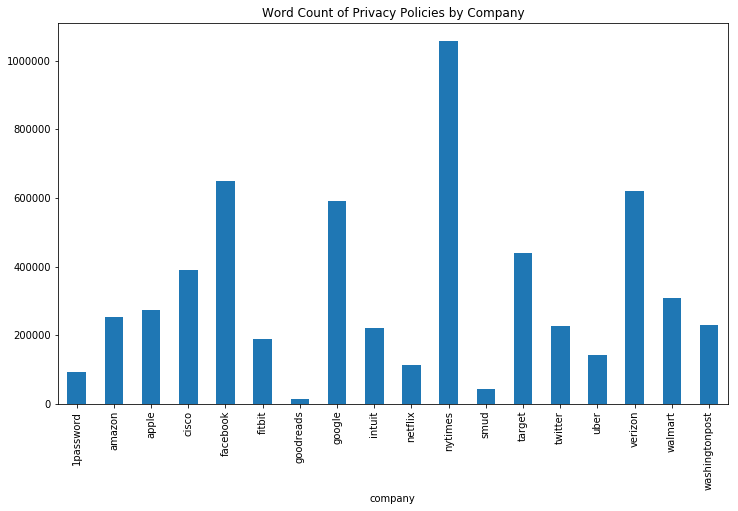

In [12]:
df_tmp = df.copy()
df_tmp['policy_len'] = df_tmp.policy_text.str.len()
grouped = df_tmp.groupby('company').policy_len.sum()
_ = grouped.plot.bar(title='Word Count of Privacy Policies by Company', figsize=(12, 7))

## Key Privacy Event Analysis

In the following sections, we investigate the impact that certain key legislative and popular events had on the privacy policies at large. We do this with a heatmap-derived visualization that shows us when certain terminology enters the vernacular of the policies per company.

In [13]:
def prepare_heatmap_data(data, ycol, xcol, valuecol):
    """
    There has to be a better way to do this... but I procrastinated :)
    
    1. Pivot data and extend a policy's np.nan/0/1 up unto the next policy revision
       (originally, companies would have a 1 in the months where there were revisions
        followed by a string of np.nans and another 1 at the next revision)
    2. Fill the gaps between policy revision columns; create a new col for each
       year-month pair between the first and last policies in the dataset and extend
       between cols as before
    3. Rebuild new, complete dataframe
    """
    ### 1
    result = data.pivot(index=ycol, columns=xcol, values=valuecol)
    for i1, row in result.transpose().iteritems():
        last = np.nan
        for i2, value in row.iteritems():
            if np.isnan(value):
                # set it equal to last value
                value = last
            result.at[i1, i2] = value
            last = value

    ### 2
    min_date = result.columns.min()
    max_date = result.columns.max()
    companies = result.index

    last = None
    dates = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for year in range(min_date.year, max_date.year + 1):
        for month in range(1, 13):
            # create name of new col
            ym = date(year=year, month=month, day=1).strftime('%Y-%m')
            # get all old cols (y-m-d) that will need to be combined into this col
            col_matches = [x for x in result.columns if ym in str(x)]
            # if there are no revisions in this y-m, then just reuse last month's data
            if last and len(col_matches) == 0:
                col_matches = last
            # set data
            for col in col_matches:
                for company in companies:
                    dates[year][month][company] = result.at[company, col]
            last = col_matches

    ### 3
    new = pd.DataFrame(index=result.index)
    for year, months in dates.items():
        for month, companies in months.items():
            # new col
            ym = date(year=year, month=month, day=1).strftime('%Y-%m')
            for company, val in companies.items():
                if ym not in new.columns:
                    # create new col with np.nan
                    new[ym] = pd.Series([np.nan] * len(new.index))
                # set value
                new.at[company, ym] = val

    return new

In [14]:
def policy_heatmap(data, title):
    # init plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(title)

    # prepare mask for null values when a company does not yet have a published privacy policy
    mask = np.zeros_like(result)
    mask[np.isnan(result)] = True

    # do plot
    # https://stackoverflow.com/questions/37790429/seaborn-heatmap-using-pandas-dataframe
    sp = sns.heatmap(data, ax=ax, fmt="g", cmap=sns.color_palette("RdBu", 7), mask=mask, cbar=False)

    # format and space xticks
    xlocs, xlabels = plt.xticks()
    #print(list(zip(xlocs, xlabels)))
    for i, x in enumerate(xlabels):
        text = ''
        if i % 6 == 0:
            text = x._text[:x._text.find('T')]
        xlabels[i]._text = text
    _ = ax.set_xticklabels(xlabels)    
    fig.autofmt_xdate()
    
    return ax

In [15]:
def review_regex_matches(data, filter_col, filter_key, buffer=20):
    return data[data[filter_col] == 1].policy_text.str.extract(
        '(.{0,' + str(buffer) + '}' + str(filter_key) + '.{0,' + str(buffer) + '})', flags=re.IGNORECASE|re.DOTALL)

In [16]:
def key_match_data(data, filter_key):
    df_copy = data.copy()
    filter_col = 'mentions_{}'.format(filter_key)
    # https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/
    df_copy[filter_col] = np.where(df_copy.policy_text.str.contains(filter_key, flags=re.IGNORECASE), 1, 0)
    print('{} / {} policies mention {}'.format(len(df_copy[df_copy[filter_col] == 1]), len(df_copy), filter_key))
    return df_copy, filter_col

### Children's Online Privacy Protection Act (COPPA)

From [Wikipedia](https://en.wikipedia.org/wiki/Children%27s_Online_Privacy_Protection_Act):

   "The act, effective April 21, 2000, applies to the online collection of personal information by persons or entities under
   U.S. jurisdiction about children under 13 years of age or children with disabilities. **It details what a website
   operator must include in a privacy policy**, when and how to seek verifiable consent from a parent or guardian, and what
   responsibilities an operator has to protect children's privacy and safety online including restrictions on the marketing
   of those under 13."

Based on the above, we should expect to see privacy policies mention their practices with children's data starting in April of 2000.

196 / 267 policies mention children


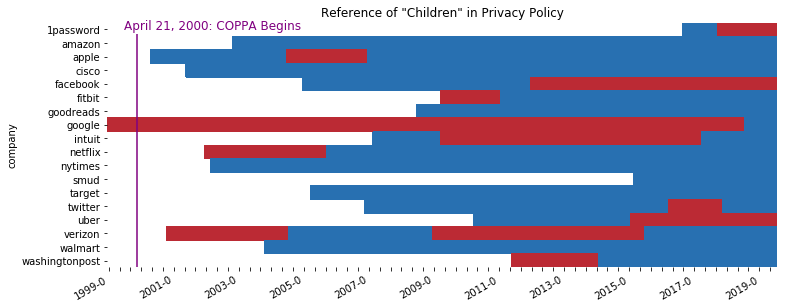

In [17]:
coppa, filter_col = key_match_data(df, 'children')
result = prepare_heatmap_data(coppa, 'company', 'policy_date', filter_col)
ax = policy_heatmap(result, 'Reference of "Children" in Privacy Policy')
# add vertical line for coppa
_ = ax.vlines(11, .8, 20, color='purple')
_ = plt.text(6, 0.5, 'April 21, 2000: COPPA Begins', color='purple', fontsize=12)

Double-checking that our matches are reasonable

In [18]:
review_regex_matches(coppa, 'mentions_children', 'children').sample(n=10)

,0
18,ices Do I Have?\nAre Children Allowed to Use Amaz
68,n the United States.Children Under Age 13Faceboo
94,in services to you.\nChildren's Privacy\nProte...
73,No information from children under age 13. If yo
67,the United States.\nChildren Under Age 13\nFa...
220,his privacy policy.\nChildren\nWe recognize th...
186,With Legal Process\nChildren's Guidelines\nYo...
188,With Legal Process\nChildren's Guidelines\nYo...
234,ormation Protected?\tChildren’s Personal Informat
284,l information about children under the age of 13


## International Safe Harbor Privacy Principles

From [Wikipedia](https://en.wikipedia.org/wiki/International_Safe_Harbor_Privacy_Principles),

"The International Safe Harbor Privacy Principles or Safe Harbour Privacy Principles were principles **developed between 1998 and 2000** in order to prevent private organizations within the European Union or United States which store customer data from accidentally disclosing or losing personal information. **They were overturned on October 6, 2015 by the European Court of Justice (ECJ)**, which enabled some US companies to comply with privacy laws protecting European Union and Swiss citizens. US companies storing customer data could self-certify that they adhered to 7 principles, to comply with the EU Data Protection Directive and with Swiss requirements. The US Department of Commerce developed privacy frameworks in conjunction with both the European Union and the Federal Data Protection and Information Commissioner of Switzerland."

Let's see if "Safe Harbor" begins to disappear from policies around the year 2015.

75 / 267 policies mention safe\s*harbor


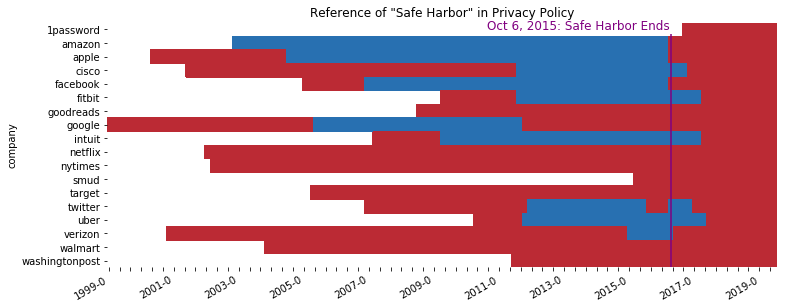

In [19]:
safeharbor, filter_col = key_match_data(df, 'safe\s*harbor')
result = prepare_heatmap_data(safeharbor, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Safe Harbor" in Privacy Policy')
# add vertical line for safe harbor
_ = ax.vlines(208, .8, 20, color='purple')
_ = plt.text(140, 0.5, 'Oct 6, 2015: Safe Harbor Ends', color='purple', fontsize=12)

In [20]:
review_regex_matches(safeharbor, filter_col, 'safe\s*harbor').sample(n=10)

,0
55,under the U.S.-E.U. Safe Harbor framework and ...
128,ly with the U.S.-EU Safe Harbor Framework and ...
66,ve your concerns.EU Safe Harbor Participation\...
247,and teens here.\nEU Safe Harbor Framework\nTw...
132,ly with the U.S.-EU Safe Harbor Framework and ...
69,ve your concerns.EU Safe Harbor ParticipationW...
246,and teens here.\nEU Safe Harbor Framework\nTw...
57,ommission.\nSwiss-US Safe Harbor Certification...
272,rivacy Policy-->\nEU Safe Harbor\nVerizon Part...
138,ly with the U.S.-EU Safe Harbor Framework and ...


### EU-US Privacy Shield

From Wikipedia,

"In October 2015 the European Court of Justice declared the previous framework called the International Safe Harbor Privacy Principles invalid. Soon after this decision the European Commission and the U.S. Government started talks about a new framework and **on February 2, 2016 they reached a political agreement**. The European Commission published the 'adequacy decision' draft, declaring principles to be equivalent to the protections offered by EU law."

As we observed, references to "Safe Harbor" begin to disappear after 2015 to be replaced by this EU-US Privacy Shield, but how many websites complied?

29 / 267 policies mention shield


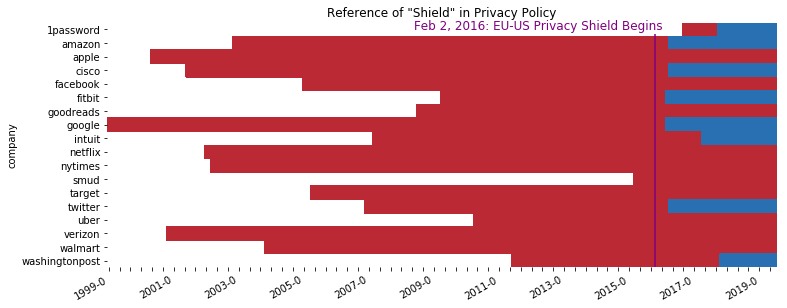

In [21]:
shield, filter_col = key_match_data(df, 'shield')
result = prepare_heatmap_data(shield, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Shield" in Privacy Policy')
# add vertical line for coppa
_ = ax.vlines(202, .8, 20, color='purple')
_ = plt.text(113, 0.5, 'Feb 2, 2016: EU-US Privacy Shield Begins', color='purple', fontsize=12)

In [22]:
review_regex_matches(shield, filter_col, 'shield').sample(n=10)

,0
121,nd Swiss-US Privacy Shield Frameworks. When we
140,wiss - U.S. Privacy Shield Frameworks and comp
118,g the EU-US Privacy Shield Framework. When we
309,rvices. Our Privacy Shield Policy governs use
60,nd Swiss-US Privacy Shields\nCisco participates
92,"nd Swiss-US Privacy Shield, and EU Commission"
5,a U.S.-E.U. Privacy Shield Framework. See http
17,".com?\nEU-US Privacy Shield\nConditions of Use,"
120,nd Swiss-US Privacy Shield Frameworks. When we
141,wiss - U.S. Privacy Shield Frameworks and comp


### Popularity of "Personal Information"

252 / 267 policies mention personal\s*information


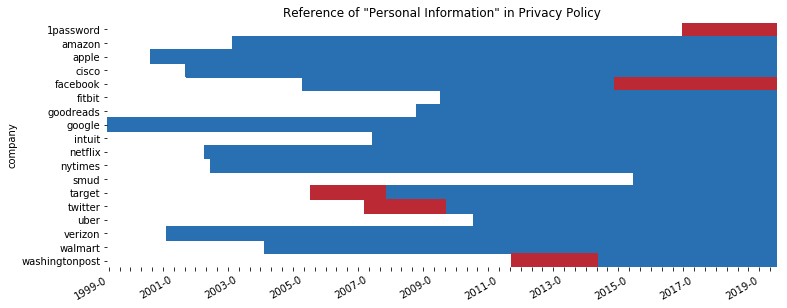

In [23]:
personalinfo, filter_col = key_match_data(df, 'personal\s*information')
result = prepare_heatmap_data(personalinfo, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Personal Information" in Privacy Policy')
# add vertical line for coppa
#_ = ax.vlines(180, .8, 20, color='purple')
#_ = plt.text(100, 0.5, 'Feb 2, 2016: EU-US Privacy Shield Begins', color='purple', fontsize=12)

In [24]:
review_regex_matches(personalinfo, filter_col, 'personal\s*information').sample(n=10)

,0
177,change or update my personal information?\nHow...
136,ormation We Collect\nPersonal information such...
268,"and fraud, collect personal information only ..."
93,e do not share your personal information excep...
218,any questions.\nYour personal information\nSMU...
181,change or update my personal information?\nHow...
250,"rovide us with some personal information, such..."
265,nd security of your personal information is ou...
153,disclosure of your personal information. As w...
25,", and disclosure of personal information that ..."


### Popularity of "Data Privacy"

15 / 267 policies mention data\s*privacy


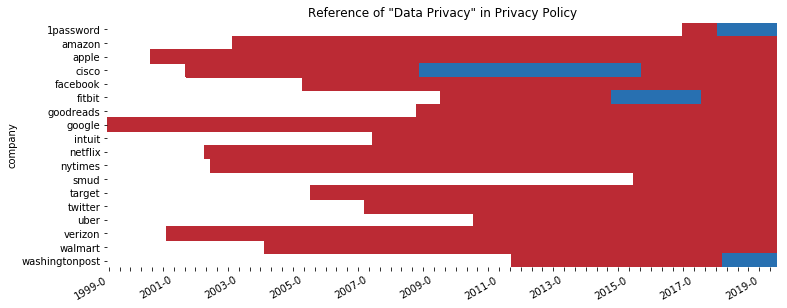

In [25]:
dataprivacy, filter_col = key_match_data(df, 'data\s*privacy')
result = prepare_heatmap_data(dataprivacy, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Data Privacy" in Privacy Policy')
# add vertical line for filter
#_ = ax.vlines(180, .8, 20, color='purple')
#_ = plt.text(100, 0.5, 'Feb 2, 2016: EU-US Privacy Shield Begins', color='purple', fontsize=12)

In [26]:
review_regex_matches(dataprivacy, filter_col, 'data\s*privacy').sample(n=10)

,0
6,otection&rdquo; for data privacy of individual...
48,nt\nLearn more about Data Privacy\nPowering th...
45,om\nLearn more about Data Privacy\nPowering th...
88,iveRamp Advertising Data Privacy Policy explai...
52,SA\nLearn more about Data Privacy\nPowering th...
46,om\nLearn more about Data Privacy\nPowering th...
5,otection&rdquo; for data privacy of individual...
4,otection&rdquo; for data privacy of individual...
309,freedoms related to data privacy. Transfers. P...
49,nt\nLearn more about Data Privacy\nPowering th...


### Do Not Track

From [Wikipedia](https://en.wikipedia.org/wiki/Do_Not_Track_legislation),

"**On December 1, 2010**, the U.S. Federal Trade Commission (FTC) published a preliminary report highlighting the consumers’ right to prevent websites from tracking their online behaviors. The central plank of the bill was to adopt a Do Not Track opt-out function to web browsers. The FTC judged that online marketers’ pervasive collection of personal information could possibly violate privacy. **This issue began to surface again in 2012** after Google announced its new privacy policy. Reps. Edward Markey, Joe Barton, and Cliff Stearns asked the FTC to investigate the legality of Google’s change of privacy policy; they sent a letter to the FTC regarding Google’s changed privacy policy."

From the above, we imagine that we might begin to see Do Not Track references in 2010/2011 with more starting to surface in and after 2012.

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


57 / 267 policies mention (do\s*not\s*track|dnt)


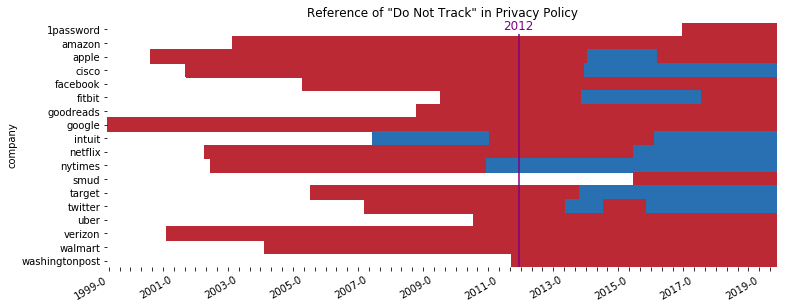

In [27]:
dnt_re = '(do\s*not\s*track|dnt)'
dnt, filter_col = key_match_data(df, dnt_re)
result = prepare_heatmap_data(dnt, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Do Not Track" in Privacy Policy')
# add vertical line for filter
_ = ax.vlines(152, .8, 20, color='purple')
_ = plt.text(146, 0.5, '2012', color='purple', fontsize=12)

In [28]:
review_regex_matches(dnt, filter_col, dnt_re).sample(n=10)

,0,1
183,Privacy Policy. We do not track or store a re...,do not track
57,"bility to enable a ""do not track"" feature that...",do not track
60,y to enable a &quot;do not track&quot; feature...,do not track
251,ngs rather than the Do Not Track browser optio...,Do Not Track
138,g\nPreferences&nbsp;\nDo Not Track:Tools and I...,Do Not Track
52,"bility to enable a ""do not track"" feature that...",do not track
125,leave our sites. We do not track URLs that you...,do not track
231,"respond to browser “do not track” signals, but...",do not track
185,Privacy Policy. We do not track or store a re...,do not track
31,.\n&nbsp;\nCalifornia Do Not Track Disclosure&...,Do Not Track


### General Data Protection Regulation (GDPR)

From Wikipedia,

"The General Data Protection Regulation (EU) 2016/679 ('GDPR') is a regulation in EU law on data protection and privacy for all individuals within the European Union (EU) and the European Economic Area (EEA). It also addresses the export of personal data outside the EU and EEA areas. The GDPR aims primarily to give control to individuals over their personal data and to simplify the regulatory environment for international business by unifying the regulation within the EU.... **The GDPR was adopted on 14 April 2016, and became enforceable beginning 25 May 2018.** As the GDPR is a regulation, not a directive, it is directly binding and applicable, but does provide flexibility for certain aspects of the regulation to be adjusted by individual member states."

We should therefore see GDPR references in 2018.

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


8 / 267 policies mention gdpr|(General Data Protection Regulation)


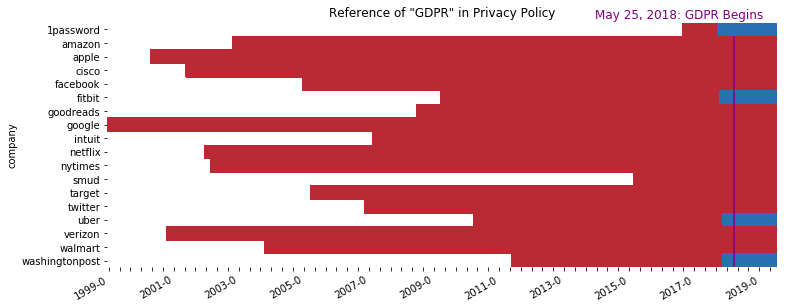

In [29]:
gdpr_re = 'gdpr|(General Data Protection Regulation)'
gdpr, filter_col = key_match_data(df, gdpr_re)
result = prepare_heatmap_data(gdpr, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "GDPR" in Privacy Policy')
# add vertical line for filter
_ = ax.vlines(231, 1, 20, color='purple')
_ = plt.text(180, -.32, 'May 25, 2018: GDPR Begins', color='purple', fontsize=12)

Interestingly, there are very few references to GDPR...

In [30]:
review_regex_matches(gdpr, filter_col, gdpr_re).sample(n=7)

,0,1
6,es.As stated in our GDPR,NaN
93,General Data Protection Regulation (&#x201C;GD...,General Data Protection Regulation
4,es.As stated in our GDPR,NaN
3,es.As stated in our GDPR,NaN
5,es.As stated in our GDPR,NaN
309,General Data Protection Regulation. To make a ...,General Data Protection Regulation
92,General Data Protection Regulation (&#x201C;GD...,General Data Protection Regulation


### Popularity of "Delete"

With GDPR came the notion of the "right to be forgotten" where you can request your data to be removed from a company's data stores. Let's see if GDPR adoption is signaled by the word "delete" making its way into privacy policies.

206 / 267 policies mention delet


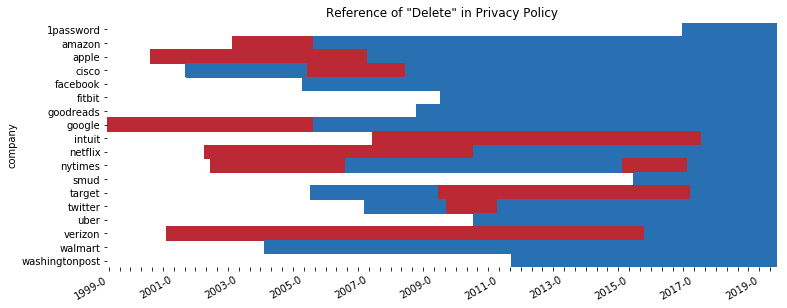

In [31]:
delete_re = 'delet'
delete, filter_col = key_match_data(df, delete_re)
result = prepare_heatmap_data(delete, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Delete" in Privacy Policy')
# add vertical line for filter
#_ = ax.vlines(105, .8, 20, color='purple')
#_ = plt.text(100, 0.5, '2012', color='purple', fontsize=12)

Surprisingly, many companies supported deleting data before GPDR. Of course, this is not a complete check. This does not tell us to what extent these companies allowed you to delete your data.

In [32]:
review_regex_matches(delete, filter_col, delete_re).sample(n=10)

,0
176,e e-mail address is deleted. Access to the ab
296,and we will work to delete it.&nbsp;\nPrivacy
44,computer until you delete them or they expir
155,that we correct or delete this personal info
113,"n access, manage or delete information that i"
188,he email address is deleted. Access to the ab
40,Unless you request deletion of your personal
37,it is inaccurate or delete the data if Apple
180,e e-mail address is deleted. Access to the ab
220,t us us and we will delete the information ab


### Popularity of "Forgotten"

0 / 267 policies mention forgotten


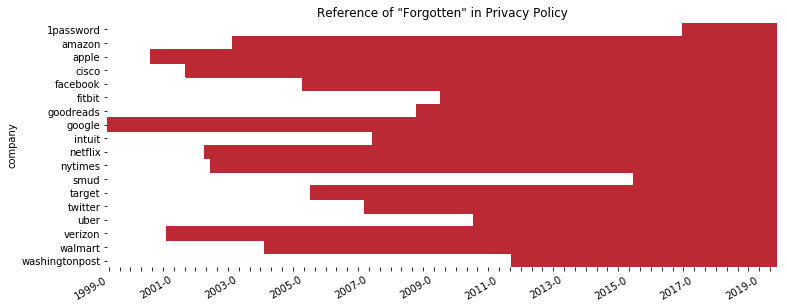

In [33]:
forgot_re = 'forgotten'
forgot, filter_col = key_match_data(df, forgot_re)
result = prepare_heatmap_data(forgot, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Forgotten" in Privacy Policy')
# add vertical line for filter
#_ = ax.vlines(105, .8, 20, color='purple')
#_ = plt.text(100, 0.5, '2012', color='purple', fontsize=12)

In [34]:
review_regex_matches(forgot, filter_col, forgot_re)

,0


### TRUSTe

## Google

In [35]:
google = df[df.company == 'google']
google.head()

,company,policy_date,policy_url,policy_path,company_id,policy_text
95,google,1999-06-09,https://policies.google.com/privacy/archive/19...,google/google-1999-06-09.txt,7,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
96,google,1999-09-20,https://policies.google.com/privacy/archive/19...,google/google-1999-09-20.txt,7,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
97,google,2001-01-04,https://policies.google.com/privacy/archive/20...,google/google-2001-01-04.txt,7,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
98,google,2004-07-01,https://policies.google.com/privacy/archive/20...,google/google-2004-07-01.txt,7,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
99,google,2005-10-14,https://policies.google.com/privacy/archive/20...,google/google-2005-10-14.txt,7,Privacy &amp; TermsOverviewPrivacy PolicyTerms...


In [36]:
google = google.apply(get_policy_text, axis=1)

In [37]:
google['policy_text_len'] = google.policy_text.str.len()

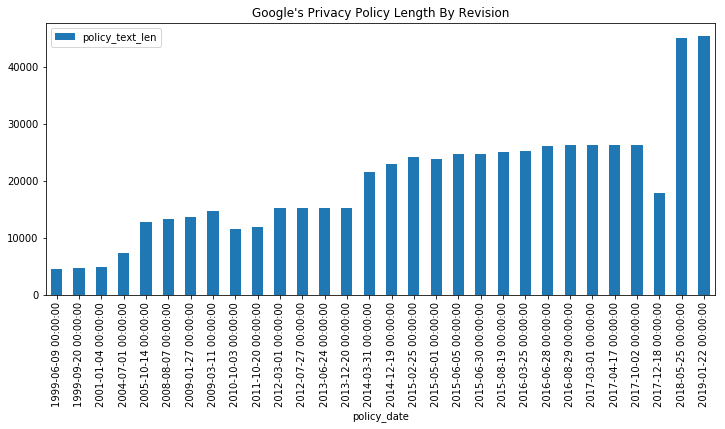

In [39]:
google[['policy_date', 'policy_text_len']].plot.bar('policy_date', title="Google's Privacy Policy Length By Revision", figsize=(12, 5))